# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Данные состоят из csv-файла `labels.csv` с двумя столбцами:
- `file_name` - название файла с фото
- `real_age` - возраст человека на фото

Сами изображения находятся в папке `/final_files`. 
Весь датасет расположен в папке `/datasets/faces/`

## Исследовательский анализ данных

### Импорт библиотек

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

### Знакомство с данными

Загрузим данные в датафрейм pandas и с помощью метода info() взглянем на общую информацию о нём.

In [17]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Размер выборки 7591 файл, пропусков нет. Оценим данные методом describe() и оценим их визуально, построив гистограмму распределения возрастов.

In [18]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

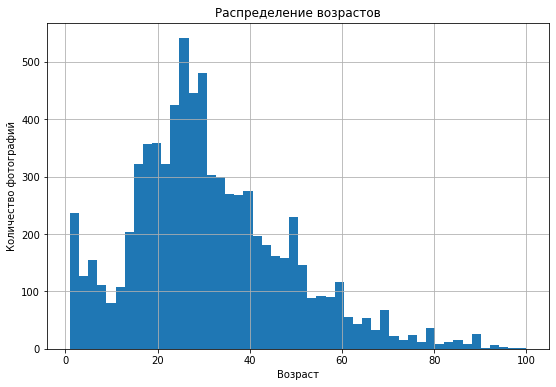

In [19]:
labels['real_age'].hist(bins=50, figsize=(9, 6))
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

#### Итоги знакомства с данными

Медиана (31) значимо ниже среднего (29), значит распределение возрастов скошено вправо. Половина выборки помечена возрастом от 20 до 41 года. То есть "ядро" выборки состоит из людей так называемого активного возраста, что вполне логично - ведь они тратят больше денег. При этом стандартное отклонение больше, чем в половину среднего говорит о достаточном разнообразии возрастов. Гистограмма это подтверждает. Минимальный возраст - 1 год, а максимальный 100 лет. Видим провал в районе 10 лет и пик одногодок. Мне кажется это странным. Взглянуть бы визуально на этих одногодок... Не выбросы ли? Посмотрим!

### Визуальная оценка фотографий

Создадим функцию, загружающую данные и выводящую фото:

In [20]:
def photos(dataframe):
    # создаём загрузчик
    datagen = ImageDataGenerator(rescale=1./255)
    # загружаем данные
    datagen_flow = datagen.flow_from_dataframe(dataframe=dataframe,
                                              directory='/datasets/faces/final_files/',
                                              x_col='file_name',
                                              y_col='real_age',
                                              target_size=(150,150),
                                              batch_size=8,
                                              class_mode='raw')
    # помещаем из "потока" фото и метки в отдельные переменные
    images, ages = next(datagen_flow)
    # создаём график и выводим на него фото без осей
    fig = plt.figure(figsize=(10,10))
    for i in range(8):
        fig.add_subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])

Поглядим на одногодок. Отсортировав `labels` по возрастанию и захватив первые 8 записей.

Found 8 validated image filenames.


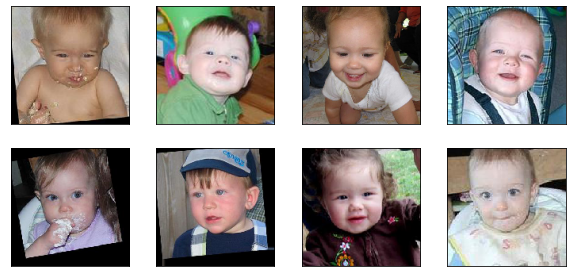

In [21]:
photos(labels.sort_values(by='real_age').head(8))

Оооооо! (с интонацией умиления) :-) Таких сладулек никак нельзя назвать выбросами!

Взглянем на старшее поколение по тому же принципу, но выведем последние 8 записей

Found 8 validated image filenames.


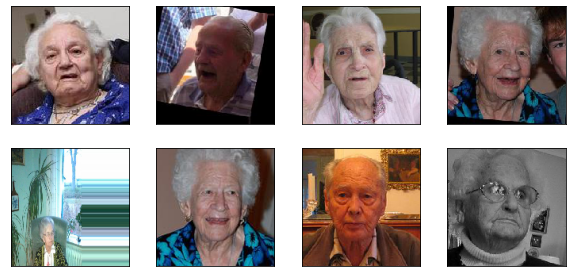

In [22]:
photos(labels.sort_values(by='real_age').tail(8))

С огромным уважением к этим людям, констатируем, что нет никаких ошибок. Тот кто формировал датасет почему-то сделал акцент не только на людях активного возраста, но и на детях (пик на гистограмме). Вероятно, чтобы выделять родителей от бездетных.

#### Итоги визуальной оценки фото

Визуально оценивая фотографии, можно увидеть, что они далеко не портретные, люди выражают разные эмоции, могут быть посторонние предметы в кадре, сам человек может быть в углу кадра... и вообще, на лице может быть размазан торт. Подборка фотографий создаёт сложности для определения возраста, что готовит её к использовании в реальной жизни. Ошибка, при этом будет больше, чем при использовании синтетических и единообразных фотографий. Но обученная на таких данных модель будет слабо работать в реальном магазине.

## Обучение модели

Необходимо определить возраст людей - это количественная переменная, а значит с помощью нейросети ResNet50 будем решать задачу регресии со всеми вытекающими:
- функция потерь MSE для лучшего обучения модели
- целевая метрика MAE
- выходной слой нейросети из одного нейрона c с функцией активации ReLu, т.к. Отрицательный возраст нам совсем не нужен и он явно больше единицы (сигмоида - мимо!)

Принимая во внимание визуальную сложность представленных фотографий будем загружать фото размером 300х300. Предполагаю, что так модель сможет "увидеть" и учесть возможные сложности.

**Код, запущенный на отдельном GPU-сервере**

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import tensorflow as tf


def load_train(path):
    dataframe = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2)
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=dataframe, 
                                                     directory=path+'final_files/', 
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(300,300),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)
    return train_datagen_flow

def load_test(path):
    dataframe = pd.read_csv(path+'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=dataframe, 
                                                    directory=path+'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(300,300),
                                                         batch_size=16,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None,
                epochs=10, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, validation_data=test_data, batch_size=batch_size,
              epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2)

    return model

```

**Вывод консоли:**

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 380 steps, validate for 95 steps

Epoch 1/10
380/380 - 142s - loss: 189.8874 - mae: 9.9955 - val_loss: 668.7077 - val_mae: 20.6097
Epoch 2/10
380/380 - 119s - loss: 85.4801 - mae: 7.0462 - val_loss: 140.8664 - val_mae: 8.8924
Epoch 3/10
380/380 - 121s - loss: 57.7738 - mae: 5.7983 - val_loss: 82.0068 - val_mae: 6.8251
Epoch 4/10
380/380 - 99s - loss: 43.1251 - mae: 5.0612 - val_loss: 108.6598 - val_mae: 7.7440
Epoch 5/10
380/380 - 108s - loss: 33.1795 - mae: 4.4284 - val_loss: 69.6311 - val_mae: 6.2611
Epoch 6/10
380/380 - 68s - loss: 25.9680 - mae: 3.9188 - val_loss: 70.8818 - val_mae: 6.3058
Epoch 7/10
380/380 - 69s - loss: 21.6518 - mae: 3.5749 - val_loss: 65.3694 - val_mae: 5.9506
Epoch 8/10
380/380 - 69s - loss: 18.2451 - mae: 3.2630 - val_loss: 87.8662 - val_mae: 7.3875
Epoch 9/10
380/380 - 117s - loss: 16.6291 - mae: 3.1268 - val_loss: 66.3054 - val_mae: 6.0073
Epoch 10/10
380/380 - 118s - loss: 14.0924 - mae: 2.8613 - val_loss: 62.0754 - val_mae: 5.8581

Test MAE: 5.8581

```

## Анализ обученной модели

Модель обучилась с финальной MAE 5,86. Бейзлайн уверенно побит за 10 эпох, прошедших примерно за 20 минут, что считаю хорошим результатом по скорости обучения. Выборки по объёму вполне достаточно для качественного обучения. Можно попробовать улучшить результат увеличив количество эпох обучения и размер выгружаемых изображений.

Результат явно зависит от качества изображений, поэтому при наличии потребности улучшать точность определения возраста, возможно магазину имеет смысл оборудовать торговые точки более качественным видеооборудованием.